In [1]:
import matplotlib.pylab as pl
import numpy as np
from scipy.optimize import fmin_cobyla
import pandas as pd
%matplotlib inline

# Creating a scientific task

In [2]:
result1_task1 = {
    'description': 'Attempt to reproduce the result 1 of this article',
    'doi': '10.1051/itmconf/20140201004',
    'reference': 'result 1, p. 4',
    'type': 'scientific task',
    'possible_outcomes': [
        'the result is reproducible',
        'the result is not reproducible'
        ]
}

# The LS-LMSR model from Augur
Heavily inspired from this blog post: [Augur’s Automated Market Maker: The LS-LMSR](http://www.augur.net/blog/augur-s-automated-market-maker-the-ls-lmsr), By Dr. Abe Othman.

The cost function for the LMSR is given by:

$$
C(\textbf{q}) = b \log \left(\sum_{i=1}^n e^{\frac{q_i}{b}} \right)
$$
and the marginal prices on each event are given by the partial derivatives of the cost function:
$$
p_j(\textbf{q}) = \frac{e^{\frac{q_j}{b}}}{\sum_{i=1}^n e^{\frac{q_i}{b}}}
$$
where $b$, which is defined as a constant in the original LMSR model of Hanson, is here defined as a variable of **q**
$$
b(\textbf{q})=\alpha \sum_{i=1}^n q_i
$$

with $\alpha$ defined as

$$
\alpha = \frac{0.1}{n \log{n}}
$$
with $n$ being the number of dimensions of $\textbf{q}$

In [29]:
class LS_LMSRMarket(object):
    def __init__(self, task, vig=0.1, init=1.0, market='LS_LMSR', b=None):
        """
        Parameters
        ----------
        task    dict
                A dictionary describing the task for which the predictive market is created.
                Keys:
                -----
                type:               str 
                                    (e.g. 'scientific task')
                description:        str
                                    description of the task to be performed
                reference:          str
                                    Internal reference (e.g. 'result 1, p. 4')
                doi:                str
                                    DOI of the related publication
                possible_outcomes:  list
                                    List of strings describing the possible outcomes of the task
                                    
        vig     float
                parameter of the `alpha` variable used to calculate the `b` variable.
                Corresponds to the market "vig" value - typically between 5 and 30 percent in real-world markets
                
        init    float
                The initial subsidies of the market, spread equally in this algorithm on all the outcomes.
        
        market  srt, 'LS_LMSR' | 'LMSR'
                The market type. If 'LMSR' is selected, then a b value should be given.
        """
        self.market = market
        if self.market == 'LSMR':
            if b == None:
                raise Exception('b value is needed for LSMR markets')
            self._b = b

        for k, v in task.items():
            setattr(self, k, v)
        self.init = init
        self.n = len(self.possible_outcomes)
        self._x = [np.ones([self.n])*init/self.n]
        self._book = []
        self.market_value = init
        self._history = []
        self.alpha = vig*self.n/np.log(self.n)
        
    @property
    def b(self):
        if self.market == 'LMSR':
            return self._b
        elif self.market == 'LS_LMSR':
            return self._b_func(self.x)
        else:
            raise Exception('market must be set to either "LMSR" or "LS_LMSR"')
    
    def _b_func(self, x):
        """Calculate the `b` equation: b=\alpha \Sigma x"""
        return self.alpha * x.sum()
        
    @property
    def book(self):
        return pd.DataFrame(self._book)
    
    @property
    def x(self):
        return self._x[-1].copy()
    
    def cost(self, x):
        return self.b*np.log(np.exp(x/self.b).sum())
    
    def _new_x(self, shares, outcome):
        new_x = self.x
        new_x[outcome] += shares        
        return new_x
            
    def price(self, shares, outcome):
        return self._price(self._new_x(shares, outcome))
        
    def _price(self, x):
        return self.cost(x)-self.cost(self.x)
    
    def register_x(self, x):
        self._x.append(x)
        
    def calculate_shares(self, paid, outcome):
        obj_func = lambda s: np.abs(self.price(s, outcome) - paid)
        return fmin_cobyla(obj_func, paid/self.p[outcome], [])
    
    def buy_shares(self, name, paid, outcome):
        shares = self.calculate_shares(paid, outcome)
        self.register_x(self._new_x(shares, outcome))
        self._book.append({'name':name, 
                           'shares':shares, 
                           'outcome':outcome, 
                           'paid':paid})
        self._history.append(self.p)
        self.market_value += paid
        print("%s paid %2.2f EUR, for %2.2f shares of outcome %d, which will give him %2.2f EUR if he wins"%(
                name, paid, shares, outcome, shares/self.x[outcome]*self.market_value))
        return shares
    
    def sell_shares(self, name, shares, outcome):
        price = self.price(-share, outcome)
        self._book.append({'name':name, 
                           'shares':-shares, 
                           'outcome':outcome, 
                           'paid':-price}) 
        self.market_value -= price        
        self._history.append(self.p)        
        return price

    def outcome_probability(self):
        K = np.exp(self.x/self.b)
        return K/K.sum()
    
    @property
    def p(self):
        return self.outcome_probability()
    
    def history(self):
        return np.array(self._history)

In [30]:
pm = LS_LMSRMarket(result1_task1, init=10., vig=0.1)

In [31]:
pm.buy_shares('Mark', 1., 0)

Mark paid 1.00 EUR, for 1.74 shares of outcome 0, which will give him 2.84 EUR if he wins


array(1.7413109375)

In [32]:
pm.buy_shares('Erik', 300., 1)
pm.buy_shares('Soeren', 1., 0)
pm.buy_shares('Albert', 3., 1)

Erik paid 300.00 EUR, for 303.33 shares of outcome 1, which will give him 305.96 EUR if he wins
Soeren paid 1.00 EUR, for 24.98 shares of outcome 0, which will give him 245.69 EUR if he wins
Albert paid 3.00 EUR, for 3.18 shares of outcome 1, which will give him 3.21 EUR if he wins


array(3.1762366179231214)

In [33]:
pm.market_value

315.0

In [34]:
pm.book

,name,outcome,paid,shares
0,Mark,0,1,1.7413109375
1,Erik,1,300,303.32944019
2,Soeren,0,1,24.9783838402
3,Albert,1,3,3.17623661792


In [43]:
total_shares = pm.book.groupby('outcome').shares.sum()
book = pm.book
book['possible_payout'] = pm.market_value * pm.book.shares / total_shares.values[pm.book.outcome.values]
book['ownership_ratio'] = pm.book.shares / total_shares.values[pm.book.outcome.values]
grouped = book.groupby('name')
df = grouped.paid.sum().to_frame(name='paid')
df['possible_payout'] = grouped.possible_payout.sum()
df

,paid,possible_payout
name,,
Albert,3,3.264261
Erik,300,311.735739
Mark,1,20.528414
Soeren,1,294.471586


In [44]:
book

,name,outcome,paid,shares,possible_payout,ownership_ratio
0,Mark,0,1,1.7413109375,20.52841,0.06516957
1,Erik,1,300,303.32944019,311.7357,0.9896373
2,Soeren,0,1,24.9783838402,294.4716,0.9348304
3,Albert,1,3,3.17623661792,3.264261,0.01036273


In [45]:
pm.x

array([  31.71969478,  311.50567681])

In [46]:
pm.market_value

315.0

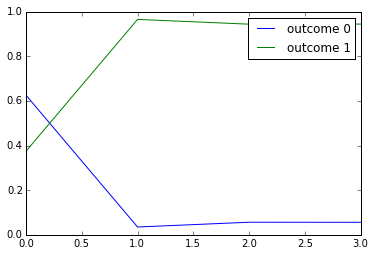

In [9]:
pl.plot(pm.history())
pl.ylim([0.,1.])
pl.legend(['outcome 0', 'outcome 1'])

# The Augur example 
Inspired from [Augur white paper](http://augur.link/augur.pdf)

Joe is creating a new event

In [10]:
new_event = {
    "type": "CreateEvent", 
    "vin": [{
        "n": 0,
        "value": 0.01000000,
        "units": "bitcoin", 
        "scriptSig": """
            <Joe’s signature>
            <Joe´s public key >"""
        }], 
    "vout": [{
        "n": 0,
        "value" : 0.01000000, 
        "units": "bitcoin", 
        "event": {
            "id": "<event hash >", 
            "description": """Hillary Clinton 
                              wins the 2016 U.S. 
                              Presidential Election.""",
            "branch": "politics", 
            "is_binary": True, 
            "valid_range": [0, 1], 
            "expiration": 1478329200, 
            "creator": "<Joe’s address>"
            },
        "address": "<base-58 event ID>", 
        "script": """
            OP_DUP 
            OP_HASH160 
            <event hash > 
            OP_EQUALVERIFY 
            OP_MARKETCHECK"""
        }]
    }

Joe is creating a Market of events

In [11]:
new_market = {
    "type": "CreateMarket", 
    "loss_limit": 1.2, 
    "vin": [{
        "n": 0,
        "value": 27.72588722,
        "units": "bitcoin", 
        "tradingFee": 0.005, 
        "scriptSig": """<Joe’s signature>
                        <Joe ’s public key >"""
        }], 
    "vout": [{
        "n": 0,
        "value": 27.72588722, 
        "units": "bitcoin", 
        "script": """
            OP_DUP
            OP_HASH160 
            OP_EVENTLOOKUP 
            OP_ISSHARES 
            OP_MARKETCHECK"""
        },
        {
        "n": 1,
        "value": 10**9,
        "units": "shares", 
        "event": "<event -1 hash >", 
        "branch": "politics", 
        "script": """
            OP_DUP
            OP_HASH160 
            OP_EVENTLOOKUP 
            OP_ISBITCOIN 
            OP_MARKETCHECK"""
        },
        {
        "n": 2,
        "value": 10**9,
        "units": "shares",
        "event": "<event-2 hash>",
        "branch": "politics", 
        "script": """
            OP_DUP
            OP_HASH160 
            OP_EVENTLOOKUP 
            OP_ISBITCOIN
            OP_MARKETCHECK"""
        }],
    "id": "<market hash>",
    "creator": "<Joe’s address>"
}

# 100 Traders example

In [12]:
n = 100
outcome = 0.001
# The amount is assumed to increase linearly with time, as the market increases its liquidity
amount = np.random.random([n]) * 100. #* (1+np.arange(n))/(1.*n)
outcomes = np.zeros([n])
outcomes[np.random.random([n])<outcome] = 1.0

Creating the new task prediction market

In [13]:
pm = LS_LMSRMarket(result1_task1, init=10., vig=0.1)

One company comes along and bet sh*t ton of money

In [14]:
pm.buy_shares('EvilMegaCorp', 1000, 1)

COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
EvilMegaCorp paid 1000.00 EUR, for 1002.00 shares of outcome 1, which will give him 1004.99 EUR if he wins


array(1002.0)

Performing the bets

In [15]:
for i, a, o in zip(range(n),amount, outcomes):
    pm.buy_shares('Trader-%d'%(i), a, int(o))

COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
Trader-0 paid 49.01 EUR, for 566.50 shares of outcome 0, which will give him 1049.74 EUR if he wins
Trader-1 paid 7.33 EUR, for 25.86 shares of outcome 0, which will give him 46.17 EUR if he wins
Trader-2 paid 3.85 EUR, for 13.06 shares of outcome 0, which will give him 22.90 EUR if he wins
Trader-3 paid 88.11 EUR, for 245.95 shares of outcome 0, which will give him 332.66 EUR if he wins
Trader-4 paid 71.24 EUR, for 152.99 shares of outcome 0, which will give him 186.37 EUR if he wins
Trader-5 paid 58.93 EUR, for 112.24 shares of outcome 0, which will give him 128.94 EUR if he wins
Trader-6 paid 76.32 EUR, for 133.16 shares of outcome 0, which will give him 144.84 EUR if he wins
Trader-7 paid 3.87 EUR, for 6.50 shares of outcome 0, which will give him 7.05 EUR if he wins
Trader-8 paid 45.04 EUR, for 73.91 shares of outcome 0, which will give him 78.26 EUR if he wins
Trader-9 paid 4.30 EUR, for 6

In [16]:
pm.buy_shares('EvilMegaCorp', 1000, 1)

COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
EvilMegaCorp paid 1000.00 EUR, for 13536.53 shares of outcome 1, which will give him 6895.32 EUR if he wins


array(13536.530024649786)

The total to pay for each outcome

In [17]:
pm.market_value

7408.2715701809821

In [18]:
total_shares = pm.book.groupby('outcome').shares.sum()
book = pm.book
book['possible_payout'] = pm.market_value * pm.book.shares / total_shares.values[pm.book.outcome.values]
grouped = book.groupby('name')
df = grouped.paid.sum().to_frame(name='paid')
df['possible_payout'] = grouped.possible_payout.sum()

In [19]:
df

,paid,possible_payout
name,,
EvilMegaCorp,2000.000000,7408.271570
Trader-0,49.009162,591.130578
Trader-1,7.329255,26.987177
Trader-10,22.761491,37.855273
Trader-11,60.384992,97.344795
Trader-12,69.143253,107.223475
Trader-13,34.941823,52.912785
Trader-14,59.495336,88.109591
Trader-15,47.673667,69.207184


In [20]:
total = pm.book.groupby('outcome').shares.sum()
total

outcome
0     7099.632084
1    14538.530025
Name: shares, dtype: float64

In [21]:
pm.book.groupby('outcome').paid.sum()

outcome
0    5398.27157
1    2000.00000
Name: paid, dtype: float64

In [22]:
pm.book.groupby('outcome').shares.sum()

outcome
0     7099.632084
1    14538.530025
Name: shares, dtype: float64

In [23]:
pm.p

array([ 0.23309422,  0.76690578])

In [24]:
pm.book.groupby('outcome').sum().values/pm.book.groupby('outcome').sum().values.sum()

array([[ 0.72966659],
       [ 0.27033341]])

Plot the market prediction history

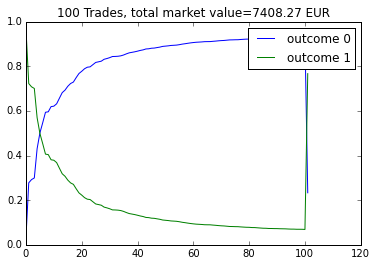

In [25]:
pl.plot(pm.history())
pl.ylim([0.,1.])
pl.legend(['outcome 0', 'outcome 1'])
pl.title('%d Trades, total market value=%2.2f EUR'%(n, pm.market_value))

The book of trades

In [26]:
book = pm.book
book['possible_win'] = pm.book.owed - pm.book.paid
book['p0'] = pm.history()[:,0]
book['p1'] = pm.history()[:,1]
book

AttributeError: 'DataFrame' object has no attribute 'owed'

In [ ]:
pm.market_value

In [ ]:
pm.p